# Clustering
_María Camila Vásquez Correa_


In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import datasets
from sklearn.datasets import load_iris
%matplotlib inline

from scipy.spatial.distance import cdist

from mpl_toolkits.mplot3d import Axes3D 
from scipy.spatial.distance import cdist

from scipy.stats import shapiro,normaltest,kurtosis,pearsonr,kendalltau,zscore,chi2_contingency, ttest_ind, spearmanr, f_oneway, ttest_rel
from statsmodels.tsa.stattools import adfuller, kpss

from bhtsne import tsne

import warnings
warnings.simplefilter('ignore')

In [2]:
# Parameters
metric = 'euclidean'
m = 2
margin = (1 / 12)
cmap = 'inferno'

decision_boundary = True

sigma = 1 / 2
beta = sigma

X_ = 0
Y_ = 1

max_epochs = 5

# Random seed
random_seed = 42
rng = np.random.RandomState() 

# Data
n_samples = n = 150
n_features = N = 4

iris = load_iris().data
X = data = iris
y = load_iris().target

Xmin = X.min(axis=0)
Xmax = X.max(axis=0)

limits = np.c_[Xmin, Xmax].T

k = n_clusters = 3 # Number of clusters
epsilon = 0.5 # max cost function
n_iter = 10000 # maximum iterations

In [3]:
def plot_mountains(
        X, Xi, m, num, margin, limits, zlim, epoch, title,
        surface=False, trisurf=False, scatter=False,
        save_fig=False, fname=None, cmap='viridis'):
    # Create a new figure and Add an axes to the current figure
    fig_size = 8
    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = plt.axes(projection='3d')

    # Plot surface
    if surface:
        Xx, Xy, Xz = Xi[X_], Xi[Y_], m.reshape(num, num)
        ax.plot_surface(Xx, Xy, Xz, cmap=cmap,
                        edgecolor='none', vmin=zlim[0], vmax=zlim[1])

    if trisurf:
        ax.plot_trisurf(Xi[:, X_], Xi[:, Y_], m, cmap=cmap,
                        antialiased=False, shade=False, edgecolors='none',
                        vmin=zlim[0], vmax=zlim[1])

    # Axis Labels
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')

    # Axis Limits
    xlim = limits[:, X_]
    xlim = xlim[0] - margin, xlim[1] + margin
    ylim = limits[:, Y_]
    ylim = ylim[0] - margin, ylim[1] + margin

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    ax.set_title(title)

    ax.view_init(50, -140)

    if save_fig:
        fig.savefig(
            '{}/{}-{}.png'.format(fname, str(epoch).zfill(2), fname),
            bbox_inches='tight')
    else:
        plt.show()

## Preprocesamiento

### Eliminar valores faltantes
También pueden ser inputados, será visto en otra oportunidad

In [4]:
iris = pd.DataFrame(iris)
N = 4
n_samples = 150
iris.isna().any().any()

False

### Normalización
La técnica de normalización a utilizar es $\frac{x_i}{x_{max}}$

In [5]:
for i in range(N):
    iris[i] = iris[i]/np.max(iris[i])

### Análisis descriptivo
* Media
* Varianza
* Mediana
* Test de distribuciones

In [6]:
iris.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,0.739662,0.694848,0.544638,0.479733
std,0.104818,0.099061,0.255840,0.304895
min,0.544304,0.454545,0.144928,0.040000
25%,0.645570,0.636364,0.231884,0.120000
50%,0.734177,0.681818,0.630435,0.520000
75%,0.810127,0.750000,0.739130,0.720000
max,1.000000,1.000000,1.000000,1.000000


In [7]:
iris.median()

0    0.734177
1    0.681818
2    0.630435
3    0.520000
dtype: float64

In [8]:
kurtosis(iris)

array([-0.57356795,  0.18097632, -1.39553589, -1.33606741])

In [9]:
descriptive = pd.DataFrame()

### Test de distribuciones y estacionaridad

In [10]:
sw = []
normal = []
dfuller = []
kp = []
for i in range(N):
    stat, p1 = shapiro(iris[i])
    sw.append(1 if p1 > 0.05 else 0)
    stat, p2 = normaltest(iris[i])
    normal.append(1 if p2 > 0.05 else 0)
    stat, p3, lags, obs, crit, t = adfuller(iris[i])#, nlags = 'auto')
    dfuller.append(1 if p3 > 0.05 else 0)
    stat, p4, lags, crit = kpss(iris[1], nlags = 'auto')
    kp.append(1 if p3 > 0.05 else 0)
descriptive['Shapiro'] = sw
descriptive['D\'Angostino'] = normal
descriptive['Dickie Fuller'] = dfuller
descriptive['Kpss'] = kp

In [11]:
descriptive

,Shapiro,D'Angostino,Dickie Fuller,Kpss
0,0,1,1,1
1,1,1,1,1
2,0,0,1,1
3,0,0,1,1


In [12]:
# 1 es 1vs2
# 2 es 2vs3
# 3 es 3vs1
distribution = pd.DataFrame()

### Tests de independencia y distribución igual

In [13]:
per = itertools.combinations(range(N),2)

In [14]:
pearson = []
spearman = []
kendall = []
chi = []
tstu = []
for i in per:
    stat, p1 = pearsonr(iris[i[0]],iris[i[1]])
    pearson.append(1 if p1 > 0.05 else 0)
    stat, p2 = spearmanr(iris[i[0]],iris[i[1]])
    spearman.append(1 if p2 > 0.05 else 0)
    stat, p4 = kendalltau(iris[i[0]],iris[i[1]])
    kendall.append(1 if p4 > 0.05 else 0)
    stat, p3, dof, expected = chi2_contingency(iris[i[0]],iris[i[1]])
    chi.append(1 if p3 > 0.05 else 0)
    stat, p5 = ttest_ind(iris[i[0]],iris[i[1]])
    tstu.append(1 if p5 > 0.05 else 0)
distribution['Pearson'] = pearson
distribution['Spearman'] = spearman
distribution['Kendall'] = kendall
distribution['Chi2'] = chi
distribution['Tstudent'] = tstu

In [15]:
distribution

,Pearson,Spearman,Kendall,Chi2,Tstudent
0,1,0,1,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
5,0,0,0,1,0


In [16]:
# Analysis of variance
stat, p = f_oneway(iris[1], iris[2], iris[3], iris[0])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=50.402, p=0.000
Probably different distributions


### Outliers

In [17]:
np.where(zscore(iris) >= 2.5)

(array([15, 33]), array([1, 1]))

## Extracción de características

In [18]:
iris1 = pd.DataFrame(iris)

In [19]:
iris1['Proportion1'] = iris1[0]/iris1[1]
iris1['Proportion2'] = iris1[1]/iris1[2]
iris1['Proportion3'] = iris1[2]/iris1[3]
iris1['Proportion4'] = iris1[0]/iris1[3]

In [20]:
iris1

,0,1,2,3,Proportion1,Proportion2,Proportion3,Proportion4
0,0.645570,0.795455,0.202899,0.08,0.811573,3.920455,2.536232,8.069620
1,0.620253,0.681818,0.202899,0.08,0.909705,3.360390,2.536232,7.753165
2,0.594937,0.727273,0.188406,0.08,0.818038,3.860140,2.355072,7.436709
3,0.582278,0.704545,0.217391,0.08,0.826460,3.240909,2.717391,7.278481
4,0.632911,0.818182,0.202899,0.08,0.773558,4.032468,2.536232,7.911392
...,...,...,...,...,...,...,...,...
145,0.848101,0.681818,0.753623,0.92,1.243882,0.904720,0.819156,0.921849
146,0.797468,0.568182,0.724638,0.76,1.403544,0.784091,0.953471,1.049300
147,0.822785,0.681818,0.753623,0.80,1.206751,0.904720,0.942029,1.028481
148,0.784810,0.772727,0.782609,0.92,1.015637,0.987374,0.850662,0.853054


# Embbeding

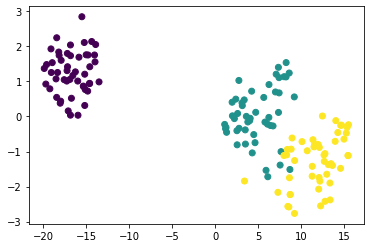

In [21]:
iris = load_iris()
Y = tsne(iris.data)
plt.scatter(Y[:, 0], Y[:, 1], c=iris.target)
plt.show()

# Clustering

## Norms

In [22]:
# np.array, np.array -> float
def euclidian(x,y):    
    dist = np.linalg.norm(x - y, axis = 1)
    return dist

In [23]:
def manhattan(x,y):
    dist = np.linalg.norm((x - y), ord=1, axis = 1)
    return dist

In [24]:
def cosine_norm(x,y):
    prod = np.matmul(x, y)
    normA = np.linalg.norm(x, axis=1)[:, np.newaxis]
    normB_T = np.linalg.norm(y, axis=0)[np.newaxis, :]
    prod_norm = np.matmul(normA, normB_T)
    cos_sim = 1 - prod / prod_norm
    return cos_sim

## K-means

In [25]:
# inicializar en aleatorio
clusters = np.random.rand(N*k).reshape((N,k))

In [26]:
def cost_function(clusters, data):
    A = data.reshape((*data.shape,1))
    B = clusters.reshape((1,*clusters.shape))
    J = euclidian(A,B)
    J = np.sum(np.min(J, axis=-1))
    return J

In [27]:
# Initialize the centers
c_random = np.random.randint(0,n_samples,k)
clusters = X[c_random].T
cluster_index = c_random

In [28]:
# Compute the matrix U
def compute_U(clusters, data):
    A = data.reshape((*data.shape,1))
    B = clusters.reshape((1,*clusters.shape))
    U = euclidian(A,B)
    U = np.argmin(U, axis=-1)    
    return U

In [29]:
def update_cluster(U, data):
    c = np.arange(k).reshape(k,1)
    mask = U == c
    mask = np.expand_dims(mask,axis = -1)
    A = np.expand_dims(data, axis = 0)
    mask = np.where(mask, A, np.nan)
    new_cluster = np.nanmean(mask, axis = 1)
    return new_cluster.T

In [30]:
# Ciclo principal
J = np.inf
i = 0
while (J > epsilon) & (i < n_iter):
    # computar la matrix U
    U = compute_U(clusters, X)
    # computar el costo
    J = cost_function(clusters, X)
    # actualizar los clusters
    clusters = update_cluster(U = U, data = X)
    i += 1

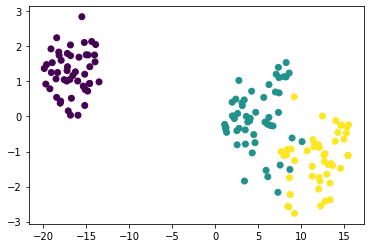

In [31]:
plt.scatter(Y[:, 0], Y[:, 1], c=U)
plt.show()

## Fuzzy c-means

In [32]:
random_seed = 0
rng = np.random.RandomState(random_seed)  # random_seed

In [33]:
# Inicializamos en aleatorio
U = rng.rand(n_clusters, n_samples)
U = U / U.sum(axis=0)
previous_J, diff = np.inf, np.inf

In [34]:
def calculate_cluster(U, data):
    Um = np.power(U, m)
    C = (Um @ data) / Um.sum(axis=1).reshape(k, 1)
    return C

In [35]:
def cost_function(U, data, clusters):
    Um = np.power(U, m)
    dist = cdist(clusters, data, metric = 'euclidean')
    J = np.sum(Um * dist)
    return J

In [36]:
def update_U(U, data, clusters):
    dist = cdist(clusters, data, metric ='euclidean')
    n_clusters = len(clusters)
    d_ij = dist.reshape(n_clusters, 1, n)
    d_kj = dist.reshape(1, n_clusters, n)

    U = d_ij / d_kj
    U = np.power(U, 2 / (m - 1))
    U = U.sum(axis=1)
    U = 1 / U
    return U

In [37]:
# Ciclo principal
i = 0
while (diff > 0) & (previous_J > epsilon) & (i < n_iter):
    # Calculamos los clusters
    clusters = calculate_cluster(U,data)
    # Calculamos el costo
    J = cost_function(U, data, clusters)
    # Calculamos la matriz de pertenencia
    U = update_U(U, data, clusters)
    # Criterio de parada
    diff = previous_J - J
    previous_J = J
    i += 1

In [38]:
U = np.argmax(U, axis = 0)

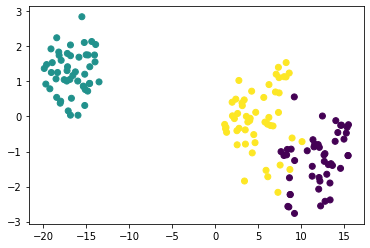

In [39]:
plt.scatter(Y[:, 0], Y[:, 1], c=U)
plt.show()

## Subtractive clustering

In [40]:
# Ratios
r_a = 1 / 2
r_b = r_a

Xmin = X.min(axis=0)
Xmax = X.max(axis=0)

limits = np.c_[Xmin, Xmax].T

In [41]:
# Mountain function
dist = cdist(X, X, metric)

m = dist / (2 * ((r_a / 2) ** 2))
m = np.exp(-m).sum(axis=1)

In [42]:
# Limits
mmin, mmax = np.minimum(0, m.min()), m.max()
zlim = [mmin, mmax]

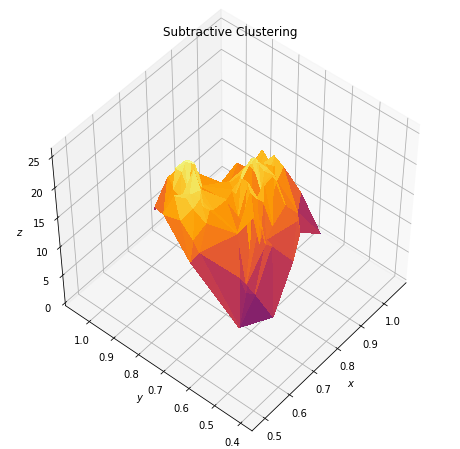

In [43]:
# Plot
epoch = 1
title = 'Subtractive Clustering'

plot_mountains(
    X, X, m, 100+1, margin, limits, zlim, epoch, title,
    trisurf=True, cmap=cmap)

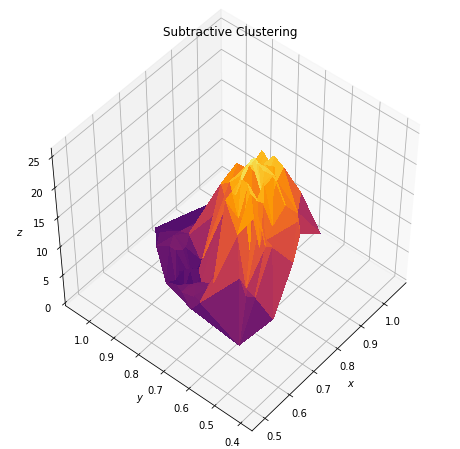

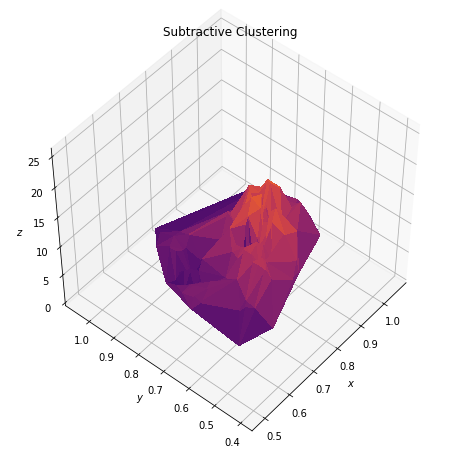

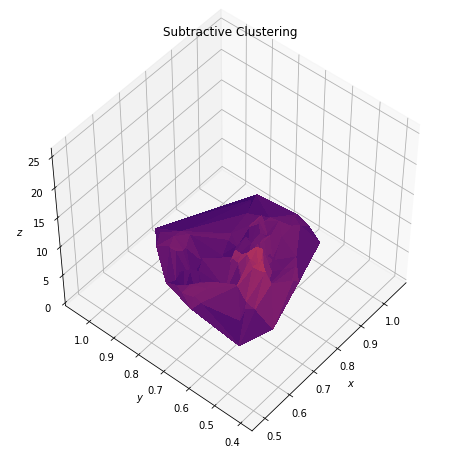

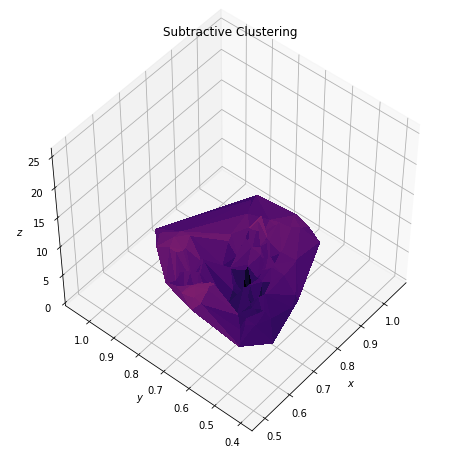

In [44]:
# Initialize clusters
C = np.zeros((0, n_features))

# Principal cycle
while m.max() > zlim[1] / 5 and epoch < max_epochs:
    # STEP 3: Add cluster
    ind = np.argmax(m)
    C = np.r_[C, X[ind].reshape(1, n_features)]

    # STEP 4: Recompute density
    dm = cdist(X, C[-1].reshape(1, n_features), metric)
    dm = dm / (2 * ((r_b / 2) ** 2))
    dm = m[ind] * np.exp(-dm)

    m = m - dm.flatten()

    # Plot
    epoch += 1
    plot_mountains(
        X, X, m, 100+1, margin, limits, zlim, epoch, title,
        trisurf=True, cmap=cmap)


In [45]:
clusters

array([[0.83778445, 0.6844817 , 0.79961566, 0.81198073],
       [0.63353834, 0.77760167, 0.21347086, 0.09897114],
       [0.74425264, 0.62142626, 0.61713528, 0.52631099]])

In [46]:
U = compute_U(clusters.T,X)

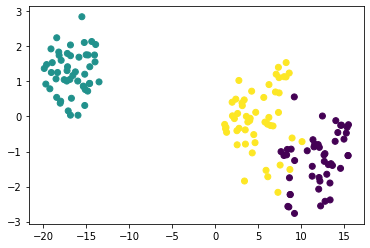

In [47]:
plt.scatter(Y[:, 0], Y[:, 1], c=U)

# Mountain clustering

In [48]:
# Create a grid
xi = []

for i in range(n_features):
    xi += [np.linspace(Xmin[i], Xmax[i], 10)]

Xi = np.meshgrid(*xi)

Grid = np.concatenate([
    matrix.flatten().reshape(10 ** n_features, 1) for matrix in Xi
], axis=1)

In [49]:
# Mountain function
dist = cdist(Grid, X, metric)

m = dist / (2 * (sigma ** 2))
m = np.exp(-m).sum(axis=1)

In [50]:
# Limits
mmin, mmax = np.minimum(0, m.min()), m.max()
zlim = [mmin, mmax]

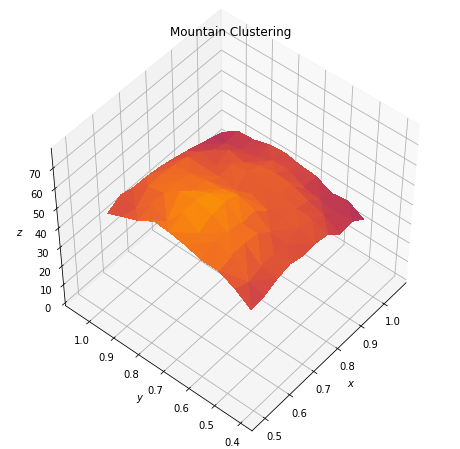

In [51]:
# Plot
epoch = 1
title = 'Mountain Clustering'

Xi = np.c_[[elem.flatten() for elem in Xi]].T

plot_mountains(
    X, Xi, m, 100+1, margin, limits, zlim, epoch, title,
    trisurf=True, cmap='inferno')


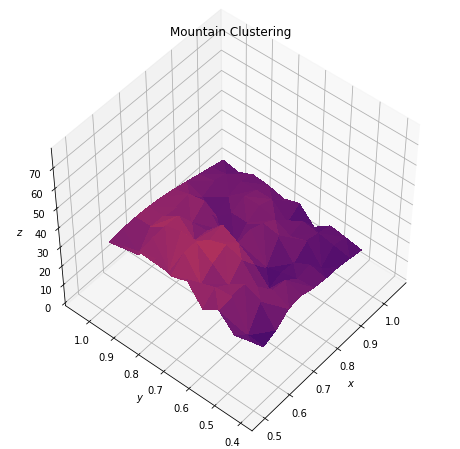

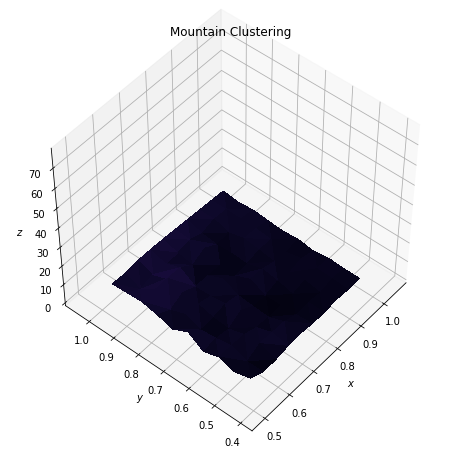

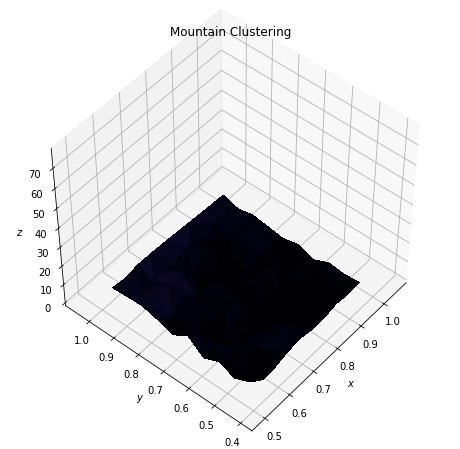

In [52]:
# Initialize clusters
C = np.zeros((0, n_features))
list_m = []

# Principal cycle
while m.max() > zlim[1] / 5 and epoch < max_epochs:
    # Add cluster
    ind = np.argmax(m)
    C = np.r_[C, Grid[ind].reshape(1, n_features)]

    # Recompute density
    dm = cdist(Grid, C[-1].reshape(1, n_features), metric)
    dm = dm / (2 * (beta ** 2))
    dm = m[ind] * np.exp(-dm)

    m = m - dm.flatten()
    list_m += [m.max()]

    # Plot
    epoch += 1
    plot_mountains(
        X, Xi, m, 100+1, margin, limits, zlim, epoch, title,
        trisurf=True, cmap='inferno')


In [53]:
clusters

array([[0.83778445, 0.6844817 , 0.79961566, 0.81198073],
       [0.63353834, 0.77760167, 0.21347086, 0.09897114],
       [0.74425264, 0.62142626, 0.61713528, 0.52631099]])

In [54]:
U = compute_U(clusters.T, X)

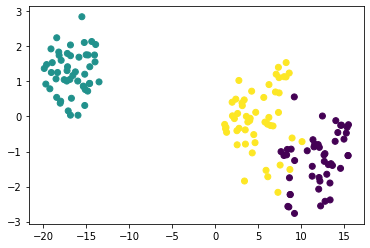

In [55]:
plt.scatter(Y[:, 0], Y[:, 1], c=U)
plt.show()